In [1]:
import numpy as np
import pylab as pl

import pycbc.psd
import pycbc.filter
import pycbc.waveform
from pycbc import frame

import configparser

In [2]:
def get_trigger_time(configfile, framefile, channel_name):
    """
    Given a frame file with GW data and parameters used to create the
    frame file specified in an ini file this function computes the
    matched filter output and outputs the time of the trigger as 
    detected in that interferometer.
    """
    
    configParser = configparser.ConfigParser()
    configParser.read(configfile)
    # Intrinsic parameters
    mass1 = configParser.getfloat('intrinsic', 'mass1')
    mass2 = configParser.getfloat('intrinsic', 'mass2')
    spin1x = configParser.getfloat('intrinsic', 'spin1x')
    spin1y = configParser.getfloat('intrinsic', 'spin1y')
    spin1z = configParser.getfloat('intrinsic', 'spin1z')
    spin2x = configParser.getfloat('intrinsic', 'spin2x')
    spin2y = configParser.getfloat('intrinsic', 'spin2y')
    spin2z = configParser.getfloat('intrinsic', 'spin2z')
    lambda1 = configParser.getfloat('intrinsic', 'lambda1')
    lambda2 = configParser.getfloat('intrinsic', 'lambda2')
    
    # Extrinsic parameter
    inclination = configParser.getfloat('extrinsic', 'inclination')
    distance = configParser.getfloat('extrinsic', 'distance')
    ra = configParser.getfloat('extrinsic', 'ra')
    dec = configParser.getfloat('extrinsic', 'dec')
    polarization = configParser.getfloat('extrinsic', 'polarization')
    coa_phase = configParser.getfloat('extrinsic', 'coa_phase')
    t_coa = configParser.getfloat('extrinsic', 't_coa')

    # Other parameters
    f_lower = configParser.getfloat('other', 'f_lower')
    f_ref = configParser.getfloat('other', 'f_ref')
    approximant = configParser.get('other', 'approximant')
    srate = configParser.getint('other', 'srate')
    asdfile_ligo = configParser.get('other', 'asdfile_ligo')
    asdfile_virgo = configParser.get('other', 'asdfile_virgo')
    
    # Reading in the frame file and converting strain data to frequency series
    frame_data = frame.read_frame(framefile, channel_name)
    stilde = frame_data.to_frequencyseries()
    
    # Creating template with exactly same parameter used to make frame
    delta_t = 1/srate
    hp, hc = pycbc.waveform.get_td_waveform(approximant='IMRPhenomPv2_NRTidalv2',
                                            mass1=mass1, mass2=mass2,
                                            lambda1=lambda1, lambda2=lambda2,
                                            spin1x=spin1x, spin1y=spin1y, spin1z=spin1z,
                                            spin2x=spin2x, spin2y=spin2y, spin2z=spin2z,
                                            distance=distance, inclination=inclination,
                                            coa_phase=coa_phase, f_lower=f_lower, f_ref=f_ref,
                                            polarization=polarization, delta_t=1/srate)
    
    # Converting template to frequency series of same delta_f as the frame
    htilde = hp.to_frequencyseries(delta_f=stilde.delta_f)
    
    # Creating LIGO and Virgo PSD objects from ASD data files
    ligo_psd = pycbc.psd.from_txt(asdfile_ligo, int(4096/stilde.delta_f) + 1,
                              stilde.delta_f, low_freq_cutoff=11)
    virgo_psd = pycbc.psd.from_txt(asdfile_virgo, int(4096/stilde.delta_f) + 1,
                               stilde.delta_f, low_freq_cutoff=11)
    
    # Resizing both template and data frequency series to that of the PSD
    htilde.resize(len(ligo_psd))
    stilde.resize(len(ligo_psd))
    
    # Compute matched-fliter output for the frame
    snr_L = pycbc.filter.matched_filter(htilde, stilde, psd=ligo_psd, low_frequency_cutoff=f_lower)
    
    rho = np.abs(snr_L.data)
    times = snr_L.sample_times.data
    
    pl.rcParams.update({'font.size': 18})
    pl.figure(figsize=(12,10))
    pl.plot(times, rho, 'r')
    pl.show()
    
    trigger_time = times[np.argmax(rho)]
    print("Trigger arrived at t = {}".format(trigger_time))
    print("Time of coalescence = {}".format(t_coa))
    observed_coa_time = trigger_time + hp.duration
    print("Observed coalescence time = {}".format(observed_coa_time))
    print("Time difference = {} ms".format((observed_coa_time - t_coa)*1e3))

    return trigger_time
    

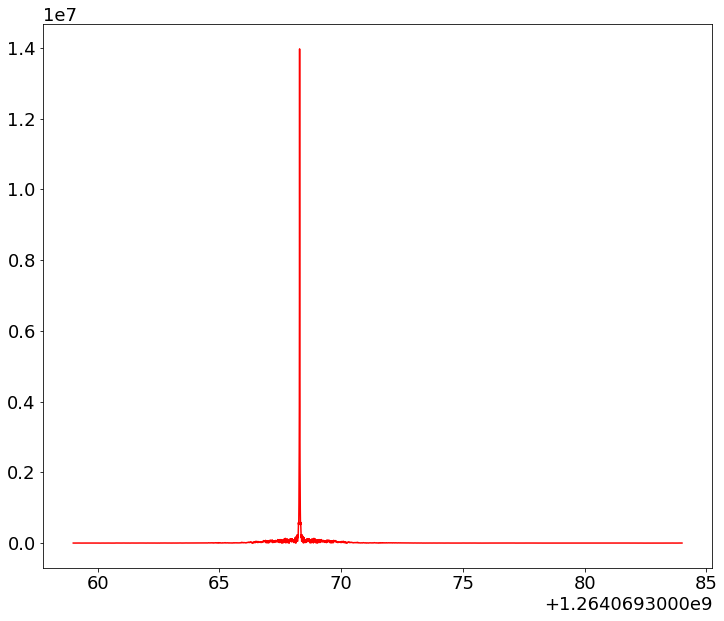

Trigger arrived at t = 1264069368.2956543
Time of coalescence = 1264069376.0
Observed coalescence time = 1264069376.0411987
Time difference = 41.19873046875 ms


In [3]:
L_end_time = get_trigger_time('inj_config.ini', 'L-L1_STRAIN-1264069359-25.gwf', 'L1:SIM-STRAIN')

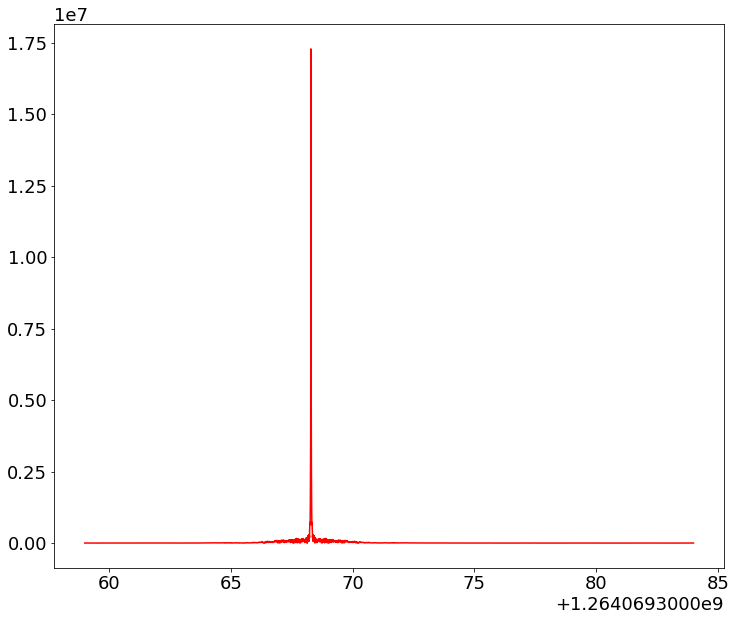

Trigger arrived at t = 1264069368.2907715
Time of coalescence = 1264069376.0
Observed coalescence time = 1264069376.036316
Time difference = 36.31591796875 ms


In [4]:
H_end_time = get_trigger_time('inj_config.ini', 'H-H1_STRAIN-1264069359-25.gwf', 'H1:SIM-STRAIN')

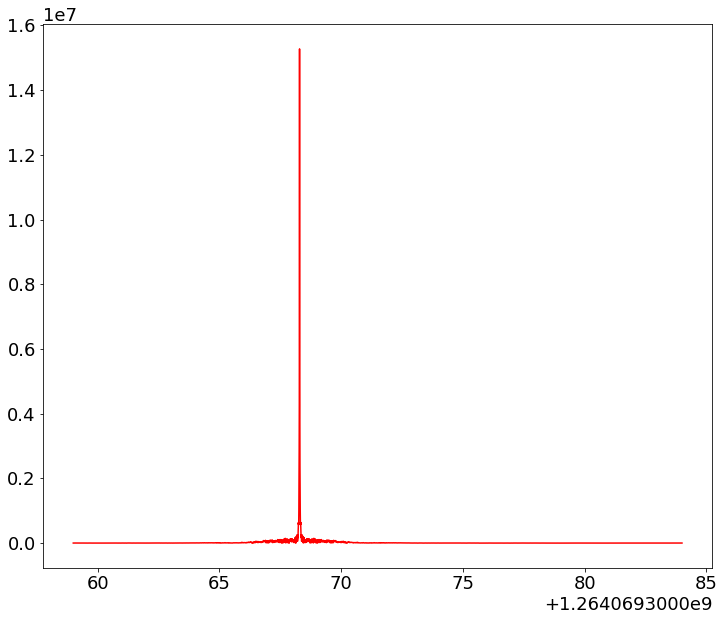

Trigger arrived at t = 1264069368.293335
Time of coalescence = 1264069376.0
Observed coalescence time = 1264069376.0388794
Time difference = 38.87939453125 ms


In [5]:
V_end_time = get_trigger_time('inj_config.ini', 'V-V1_STRAIN-1264069359-25.gwf', 'V1:SIM-STRAIN')

In [6]:
print("Time delay between Hanford and Livingston = {} ms".format((H_end_time - L_end_time)*1e3))
print("Time delay between Hanford and Virgo = {}".format((H_end_time - V_end_time)*1e3))
print("Time delay between Livingston and Virgo = {} ms".format((L_end_time - V_end_time)*1e3))

Time delay between Hanford and Livingston = -4.8828125 ms
Time delay between Hanford and Virgo = -2.5634765625
Time delay between Livingston and Virgo = 2.3193359375 ms
